# Problem Set 2

## Question 4

Do Exercise 26.12 in Hansen (2022).

Use the ``cps09mar`` dataset and the subset of men. Estimate a multinomial logit model for marriage status similar to Figure 26.1 as a function of age. How do your findings compare with those for women?

## Manually calculating version:

In [1]:
def Q4(men = True):
    
    import pandas as pd
    import numpy as np
    from scipy.optimize import minimize

    #Import the data
    raw_data = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta")

    #Create new marriage status variable according to our needs
    #``marriage_status``
    # 1: Never married/ 2: Married/ 3. Divorced/ 4. Seperated
    marital_map = {7:1,
                   5:3,
                   6:4}
    marital_map.update(dict.fromkeys(list(range(1,5)),2))
    raw_data["marriage_status"] = raw_data["marital"].map(marital_map)
    
    if men == True:
        raw_data = raw_data[raw_data["female"] == 0]  #Men only
    else:
        raw_data = raw_data[raw_data["female"] == 1]  #Female only

    #Selecting only relevant variables: ``age`` and ``marriage_status`` 
    #Drop unrelevant observations (not in interested groups according to their marriage status)
    data = raw_data[["age","marriage_status"]].dropna()

    #Define the log-likelihood function
    def exp_fn(data, betai, alphai):
        return np.exp(data*betai + alphai)

    def log_likelihood(beta):
        P_j_list = []
        for i in range(4):
            j_data = data[data["marriage_status"]== i+1]["age"].values
            for k in range(4):
                if k == 0:
                    P_comp = np.array([exp_fn(data = j_data, betai = beta[k], alphai = beta[4+k]).tolist()])
                else:
                    P_comp_temp = exp_fn(data = j_data, betai = beta[k], alphai = beta[4+k])
                    P_comp_temp = np.array([P_comp_temp.tolist()])
                    P_comp = np.append(P_comp, P_comp_temp, axis = 0)
            summation = sum(P_comp[l] for l in range(4))
            P_j = P_comp[i]/summation
            P_j_list.append(np.log(P_j))
        ll = sum([sum(g) for g in P_j_list])
        return -ll

    #Initial values
    x0 = [0,0,0,0,0,0,0,0]

    #Do the optimization (bj[0:4]: beta for group 1 to 4; bj[4:7]: alpha (intercept) for group 1 to 4)
    mle = minimize(log_likelihood, x0, method = 'Nelder-Mead')
    bj = mle.x
    
    #Plot the results
    import matplotlib.pyplot as plt

    #Get the probability
    def p(j, x):  #j: group/ x:age
        for k in range(4):
            if k == 0:
                P_comp = exp_fn(data = x, betai = bj[k], alphai = bj[4+k])
                P_comp = [[P_comp]]
            else:
                P_comp_temp = exp_fn(data = x, betai = bj[k], alphai = bj[4+k])
                P_comp_temp = [P_comp_temp]
                P_comp.append(P_comp_temp)
        summation = sum(P_comp[l][0]for l in range(4))
        P_j = P_comp[j]/summation
        return P_j[0]

    x = np.linspace(20, 80, 100)

    plt.plot(x, p(0,x), label = "Never married")   #never married
    plt.plot(x, p(1,x), label = "Married") #married
    plt.plot(x, p(2,x), label = "Divorced")  #divorce
    plt.plot(x, p(3,x), label = "Seperated") #seperated
    plt.ylim(0,1)
    plt.legend()
    if men == True:
        gender = " Men"
    else:
        gender = " Women"
    plt.title("Probability of Marital Status Given Age for"+ gender)
    plt.xlabel("Age")
    plt.show()

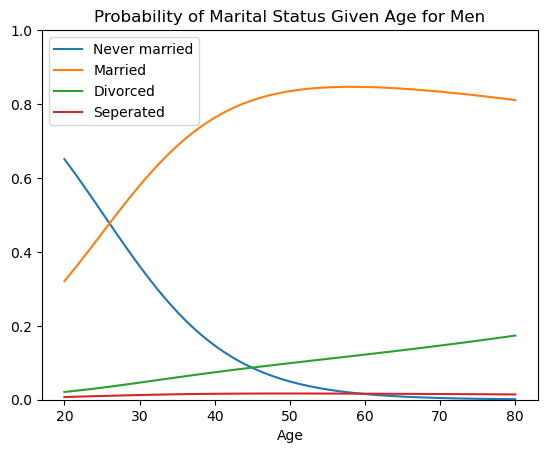

In [2]:
#Result for Men
Q4()

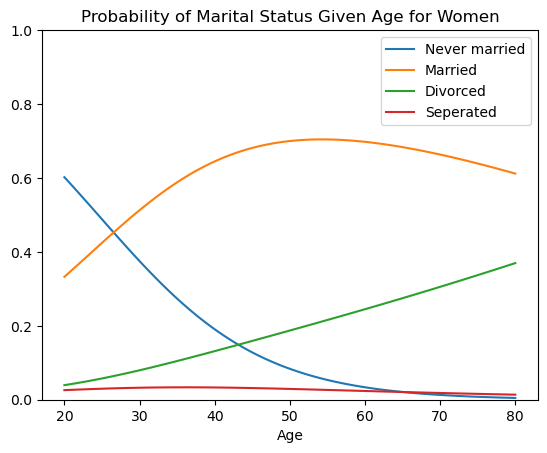

In [3]:
#Result for Women
Q4(men = False)

We can see that the pattern is similar across men and women. However, probability for elder women to get divorced is noticeably higher when compare to men. 

## Pacakge version:

In [4]:
#Below is the code to check with the standard package provided in pythons

def Q4_packagever(men = True):
    import pandas as pd
    import numpy as np
    from scipy.optimize import minimize

    #Import the data
    raw_data = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta")

    #Create new marriage status variable according to our needs
    #``marriage_status``
    # 1: Never married/ 2: Married/ 3. Divorced/ 4. Seperated
    marital_map = {7:1,
                   5:3,
                   6:4}
    marital_map.update(dict.fromkeys(list(range(1,5)),2))
    raw_data["marriage_status"] = raw_data["marital"].map(marital_map)

    if men == True:
        raw_data = raw_data[raw_data["female"] == 0]  #Men only
    else:
        raw_data = raw_data[raw_data["female"] == 1]  #Female only

    #Selecting only relevant variables: ``age`` and ``marriage_status`` 
    #Drop unrelevant observations (not in interested groups according to their marriage status)
    data = raw_data[["age","marriage_status"]].dropna()

    #Implement the logisitc Regression model provided by sklearn 
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    model.fit(data["age"].values.reshape(-1, 1), data["marriage_status"].values)

    #Get the predicted probability
    x = np.linspace(20, 80, 100).reshape(-1,1)
    pred = model.predict_proba(x)

    #Plot the result
    import matplotlib.pyplot as plt
    plt.plot(x, pred)
    plt.ylim(0,1)
    plt.legend(["Never married", "Married", "Divorced", "Seperated"])
    if men == True:
        gender = " Men"
    else:
        gender = " Women"
    plt.title("Probability of Marital Status Given Age for"+ gender)
    plt.xlabel("Age")
    plt.show()

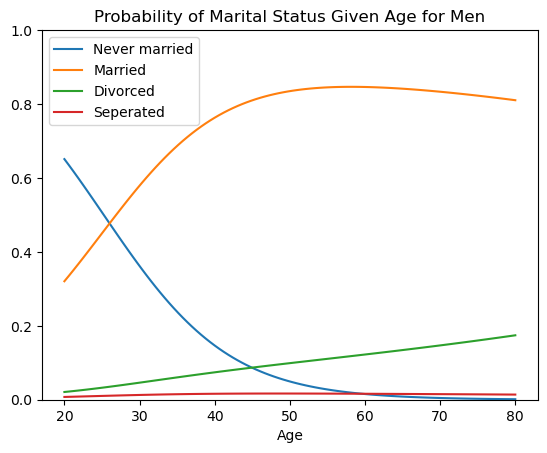

In [5]:
#Men only
Q4_packagever()

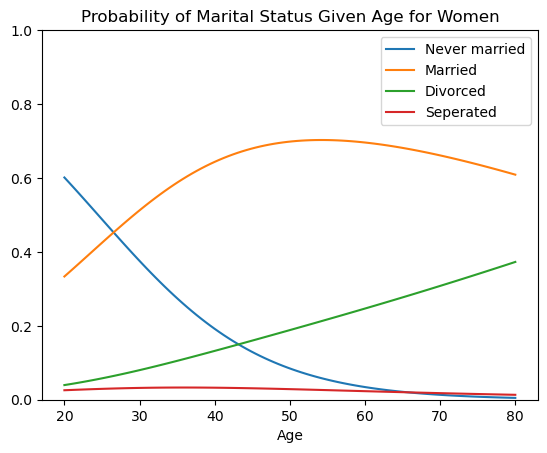

In [6]:
#Female only
Q4_packagever(men = False)

We can see the two versions conincide with each other.